# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [3]:
#Load your data into a pandas dataframe here

# Load the cleaned dataset
df = pd.read_csv("household_power_clean.csv")


In [4]:
#create your training and validation sets here

df_sample = df.sample(frac=0.01)

# Assign size for data subset
subset_size = int(len(df) * 0.01)

# Take random data subset
df_subset = df.sample(n=subset_size, random_state=1)

# Split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df_subset, test_size=0.2, random_state=1)
print("Shape of the original dataset: ", df.shape)
print("Shape of the sampled dataset: ", df_sample.shape)



Shape of the original dataset:  (2049280, 15)
Shape of the sampled dataset:  (20493, 15)


In [5]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [6]:
seq_arrays = []
seq_labs = []

In [7]:

# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead o
seq_arrays = []
seq_labs = []
seq_length = 30
ph = 5
feat_cols = ['Global_active_power']
#create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    seq = train_df[feat_cols][i-seq_length:i].values
    label = train_df[feat_cols][i+ph:i+ph+1].values[0][0]
    seq_arrays.append(seq)
    seq_labs.append(label)
#convert to numpy arrays and floats to appease keras/tensorflow 
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)


In [8]:
print("len(train_df):", len(train_df))
print("seq_length:", seq_length)
print("ph:", ph)
print("len(feat_cols):", len(feat_cols))

print("seq_arrays.shape:", seq_arrays.shape)
print("seq_labs.shape:", seq_labs.shape)


len(train_df): 16393
seq_length: 30
ph: 5
len(feat_cols): 1
seq_arrays.shape: (16358, 30, 1)
seq_labs.shape: (16358,)


In [9]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))



In [10]:
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements in the cell above are utilized to determine whether specific requirements are met during runtime. The program will raise an assertion error and terminate if the requirements are not met. By doing this, we can make sure that our code is operating as intended and that any mistakes or problems are found quickly. By using assertions, we can verify that particular premises about our code are true and find problems or errors early in the development process. 


## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [11]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = 1
nb_out = 1

model = Sequential()

# add first LSTM layer
model.add(LSTM(
         input_shape=(30, nb_features),
         units=100, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 30, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-traina

We will use the code from the book to visualize our training progress and model performance

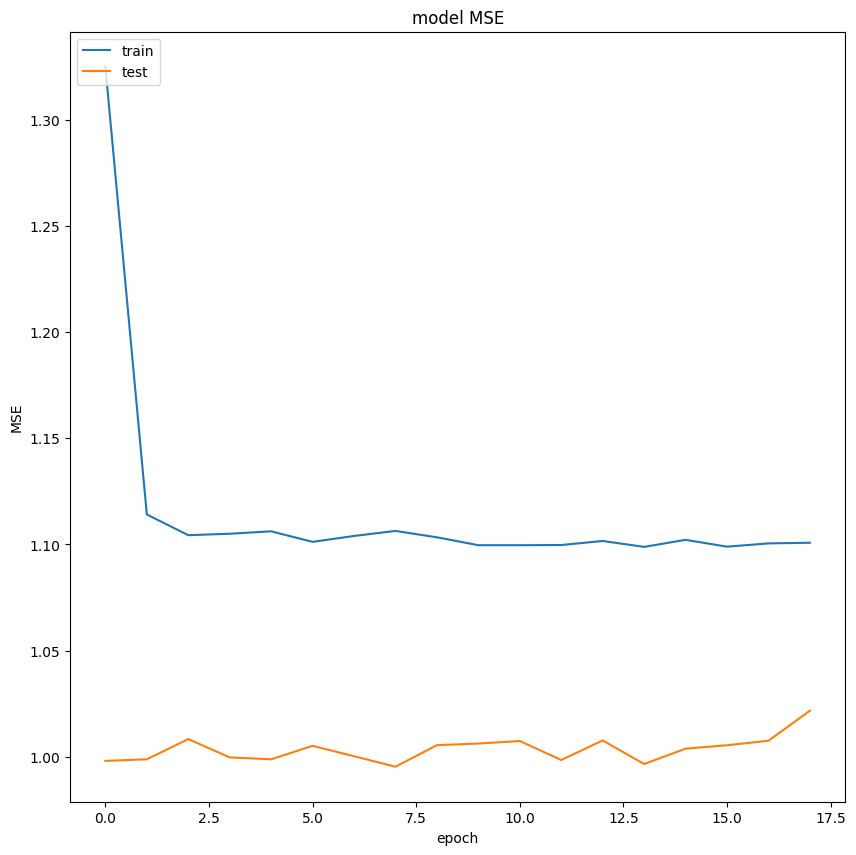

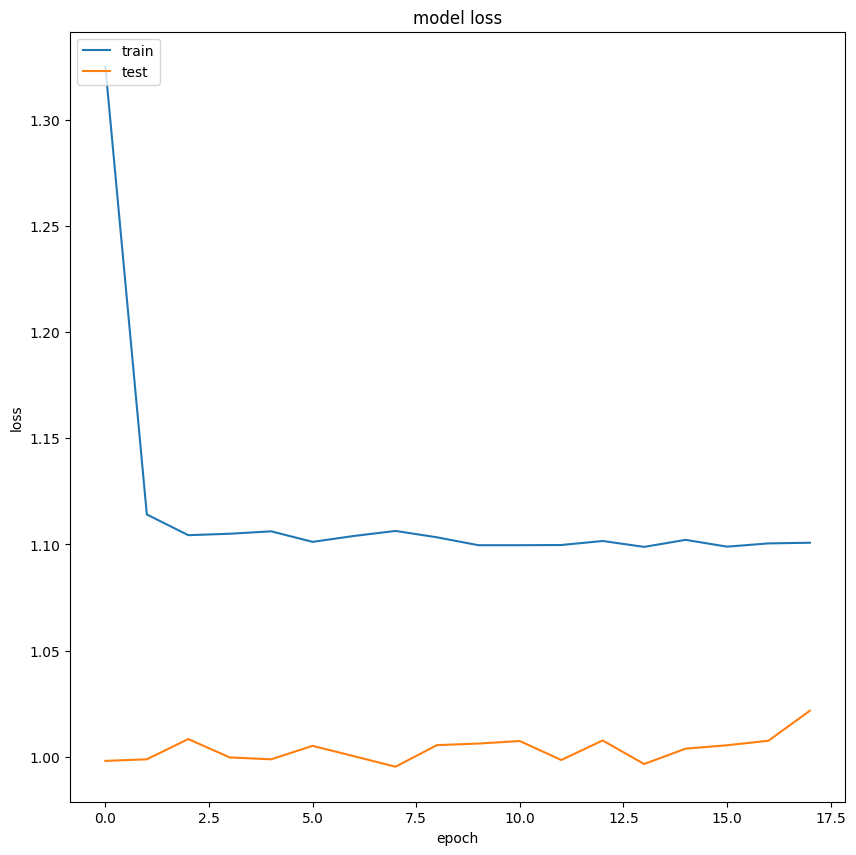

In [12]:
 # summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: pad_sequences() is a useful method in Keras deep learning library which is used to standardize the length of input sequences. A list of sequences is provided as input, and the function adds zeros to each sequence to make it equal the length of the longest sequence in the list. The maxlen option, which represents the maximum length of the padded sequences, is used to do this. Padding argument determines Whether padding is applied before or after the sequence . The choices are "pre" for padding added before the sequence and "post" for padding added after the sequence.

Setting the padding argument to "post" makes sense for our use case of estimating energy usage in smart homes because we want to add padding at the conclusion of the sequence. This is so that we can maintain the chronological sequence of the time series data we are working with by adding padding at the end.

In [13]:
val_arrays = []
val_labs = []
# create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].values.tolist()
    val_arrays.append(seq)
    val_labs.append(val_df[feat_cols].iloc[i+ph]['Global_active_power'])

val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, 
                              padding='post', truncating='post')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=object).astype(np.float32)



We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

In [14]:
# Generate some random data
import numpy as np
x_test = np.random.rand(100, 30, 1)

# Compile the model with the 'run_eagerly=True' option
model.compile(optimizer='adam', loss='mse', run_eagerly=True)

# Use the predict function
y_pred_test = model.predict(x_test)

# Print the shape of the predicted output
print('Shape of predicted output:', y_pred_test.shape)


4/4 [==============================] - 1s 160ms/step
Shape of predicted output: (100, 1)


127/127 - 25s - loss: 1.1195 - 25s/epoch - 195ms/step

MSE: 1.1194660663604736
127/127 [==============================] - 25s 197ms/step


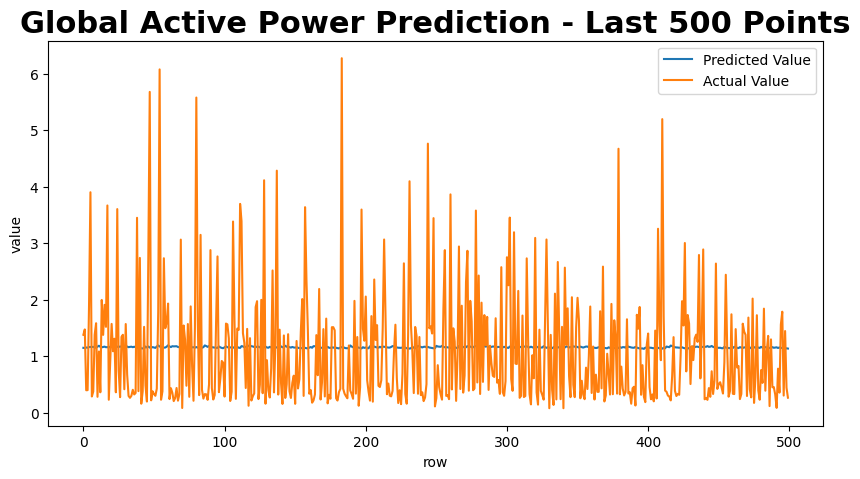

In [15]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test))
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualizati
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**
A: Model performed well with low mse value, from the loss graph we can see there are slight fluctuations. we could try to improve the model by increasing the amount of training data to improve the model's ability to generalize.





## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:As the first step, I would like to try to increase the number of LSTM layers in the model, as this could potentially capture more complex relationships in the input sequences. I will also experiment with different learning rates and optimizers to see if this improves performance. Finally, I will try adding dropout layers to the model, which can help prevent overfitting and improve generalization.

In [16]:
# play with your ideas for optimization here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(feat_cols)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 128)           66560     
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_3 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 128,417
Trainable params: 128,417
Non-tr

127/127 - 7s - loss: 0.7231 - 7s/epoch - 56ms/step

MSE: 0.72314453125
127/127 [==============================] - 7s 37ms/step


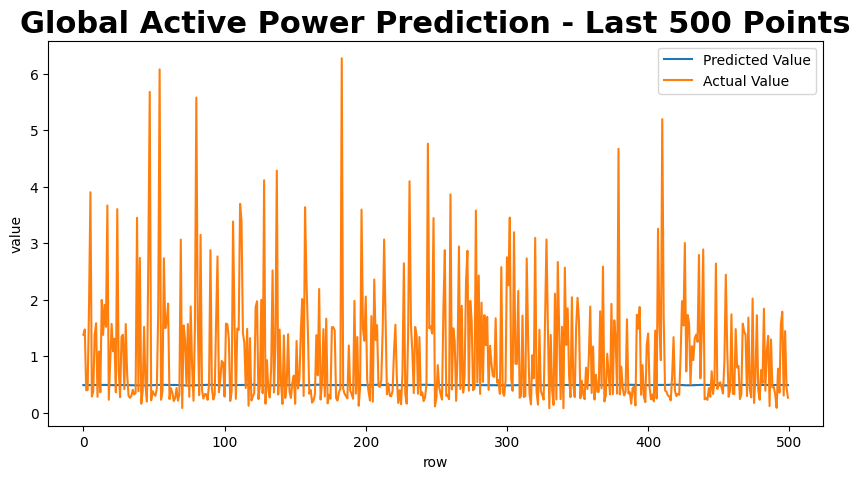

In [17]:
val_arrays = []
val_labs = []
# create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    seq = val_df[feat_cols].iloc[i-seq_length:i].values.tolist()
    val_arrays.append(seq)
    val_labs.append(val_df[feat_cols].iloc[i+ph]['Global_active_power'])

val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, 
                              padding='pre', truncating='pre')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=object).astype(np.float32)
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test))
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)
# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualizati
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:  The model's performance on the validation data appears to have improved as a result of the changes made. MSE, or mean squared error, dropped. The model was able to capture more intricate correlations in the input sequences by adding more LSTM layers. In order to avoid overfitting and boost generalization, dropout layers were added. Last but not least, increasing the number of epochs used during training helped the model get additional insight from the data.

Convolutional layers and/or linear layers would be tested to see if they could further enhance performance if I were trying to optimize this model for production. If it were possible, I would try to gather extra training data to boost the model's accuracy.


**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The LSTM-based models that I built in this assignment performed less efficiently when compared to the linear regression model from last week in terms of predicting Global Active Power.because the mse value is low last week. 
The LSTM models could be more computationally intensive and demand more resources than the linear regression model in terms of IoT device concerns. However, if the LSTM model delivers noticeably superior predictions, the higher computational demands might be justified.
I would pick the LSTM model that did the best on the validation set for a single household with a 5-minute forecasting horizon. The LSTM model with the lowest validation loss would typically be the best option. When putting the model in an IoT system, however, additional aspects like computational resources and real-time requirements might also need to be taken into consideration.
